In [10]:
import os
from google.colab import drive  # Google Drive support
drive.mount('/content/drive')   # Mount Google Drive

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Assignment

**1. Define Path**

In [11]:
# Train set path
train_path = '/content/drive/MyDrive/COS30082/A1/train'
test_path = '/content/drive/MyDrive/COS30082/A1/test'

**2. Image Processing**

In [28]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
import pandas as pd
import os

'''
We apply different pipelines for the CNN (base and augmented models), to ResNet based model
This is to since these 2 types of models require different preprocessing pipelines, specifically including:
- Different image size
- Different normalization
'''

# Constants (img size, batch size, random state)
IMG_SIZE = (128, 128)     # For CNN models' image size
IMG_SIZE_R50 = (224, 224) # For ResNet50 transferred exclusively
BATCH_SIZE = 32
SEED = 42

# List of class names
class_names = sorted(os.listdir(train_path))
num_classes = len(class_names)

# Load file paths and labels
file_paths = []
labels = []

# Enumerate classes name
for class_index, class_name in enumerate(class_names):
    class_folder = os.path.join(train_path, class_name)
    for fname in os.listdir(class_folder):
        file_paths.append(os.path.join(class_folder, fname))
        labels.append(class_name)

# Split train set into train/val sets (80/20 porportionally)
train_paths, val_paths, train_labels, val_labels = train_test_split(
    file_paths, labels, test_size=0.2, stratify=labels, random_state=SEED)

# Apply processing and augumentation on train/val data
train_gen = ImageDataGenerator(rescale=1./255, horizontal_flip=True, rotation_range=20, zoom_range=0.2)
val_gen = ImageDataGenerator(rescale=1./255)

# Load and label the images for train/val set
train_data = train_gen.flow_from_dataframe(
    dataframe=pd.DataFrame({'filename': train_paths, 'class': train_labels}),
    x_col='filename', y_col='class',
    target_size=IMG_SIZE, class_mode='categorical', batch_size=BATCH_SIZE, shuffle=True)
val_data = val_gen.flow_from_dataframe(
    dataframe=pd.DataFrame({'filename': val_paths, 'class': val_labels}),
    x_col='filename', y_col='class',
    target_size=IMG_SIZE, class_mode='categorical', batch_size=BATCH_SIZE, shuffle=False)

# ResNet50 model processing pipeline exclusively
from tensorflow.keras.applications.resnet50 import preprocess_input
r50_train_gen = ImageDataGenerator(preprocessing_function=preprocess_input)
r50_val_gen = ImageDataGenerator(preprocessing_function=preprocess_input)
r50_train_data = r50_train_gen.flow_from_dataframe(
    dataframe=pd.DataFrame({'filename': train_paths, 'class': train_labels}),
    x_col='filename', y_col='class',
    target_size=IMG_SIZE_R50, class_mode='categorical', batch_size=BATCH_SIZE, shuffle=True)
r50_val_data = r50_val_gen.flow_from_dataframe(
    dataframe=pd.DataFrame({'filename': val_paths, 'class': val_labels}),
    x_col='filename', y_col='class',
    target_size=IMG_SIZE_R50, class_mode='categorical', batch_size=BATCH_SIZE, shuffle=False)


Found 8006 validated image filenames belonging to 10 classes.
Found 2002 validated image filenames belonging to 10 classes.
Found 8006 validated image filenames belonging to 10 classes.
Found 2002 validated image filenames belonging to 10 classes.


**3. Build and TrainCNN Models**

*a. Base CNN*

In [ ]:
def build_cnn_base():
    model = tf.keras.Sequential([
        tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(*IMG_SIZE, 3)),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

*b. CNN with Dropout & Augmentation*

In [ ]:
def build_cnn_augmentation():
    model = tf.keras.Sequential([
        tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(*IMG_SIZE, 3)),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(256, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

c. Transfer Learning with ResNet50

In [32]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model

def build_resnet50_transfer():
    r50_model = ResNet50(weights='imagenet', include_top=False, input_shape=(*IMG_SIZE_R50, 3))
    r50_model.trainable = False  # Freeze base
    x = r50_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.5)(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.3)(x)
    predictions = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs=r50_model.input, outputs=predictions)
    model.compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

*d. Train CNN models*

In [33]:
# Train models
model_base = build_cnn_base()
model_augmentation = build_cnn_augmentation()
model_resnet50 = build_resnet50_transfer()

# # Train models by 20 epochs and record metrics by each epoch
history_base = model_base.fit(train_data, epochs=20, validation_data=val_data)
print("Base model training completed")
history_augmentation = model_augmentation.fit(train_data, epochs=20, validation_data=val_data)
print("Processed model training completed")
history_resnet50 = model_resnet50.fit(r50_train_data, epochs=20, validation_data=r50_val_data)
print("ResNet50 transfer learning model training completed")

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
251/251 ━━━━━━━━━━━━━━━━━━━━ 345s 1s/step - accuracy: 0.2215 - loss: 2.6588 - val_accuracy: 0.6214 - val_loss: 1.2762
Epoch 2/20
251/251 ━━━━━━━━━━━━━━━━━━━━ 329s 1s/step - accuracy: 0.4888 - loss: 1.5483 - val_accuracy: 0.6763 - val_loss: 1.0257
Epoch 3/20
251/251 ━━━━━━━━━━━━━━━━━━━━ 323s 1s/step - accuracy: 0.5584 - loss: 1.2881 - val_accuracy: 0.6953 - val_loss: 0.9379
Epoch 4/20
251/251 ━━━━━━━━━━━━━━━━━━━━ 320s 1s/step - accuracy: 0.6125 - loss: 1.1762 - val_accuracy: 0.7183 - val_loss: 0.8683
Epoch 5/20
251/251 ━━━━━━━━━━━━━━━━━━━━ 318s 1s/step - accuracy: 0.6432 - loss: 1.0853 - val_accuracy: 0.7273 - val_loss: 0.8309
Epoch 6/20
251/251 ━━━━━━━━━━━━━━━━━━━━ 317s 1s/step - accuracy: 0.6569 - loss: 1.0173 - val_accuracy: 0.7388 - val_loss: 0.8007
Epoch 7/20
251/251 ━━━━━━━━━━━━━━━━━━━━ 320s 1s/step - accuracy: 0.6739 - loss: 0.9757 - val_accuracy: 0.7388 - val_loss: 0.7787
Epoch 8/20
251/251 ━━━━━━━━━━━━━━━━━━━━ 329s 1s/step - accuracy: 0.6815 - loss: 0.9535 - val_accu

**4. Evaluate Models**

In [35]:
import os
import tensorflow as tf

# Path to model directory
model_path = '/content/drive/MyDrive/COS30082/A1/model'

# === Load models ===
# Base CNN model
model_base = tf.keras.models.load_model(os.path.join(model_path, 'cnn_base_model.h5'))
print("✅ Base model loaded.")

# CNN with Augmentation & Dropout
model_augmentation = tf.keras.models.load_model(os.path.join(model_path, 'cnn_augmented_model.h5'))
print("✅ Augmented model loaded.")

# ResNet50 Transfer Learning model
model_resnet50 = tf.keras.models.load_model(os.path.join(model_path, 'resnet50_transferred_model.keras'))
print("✅ ResNet50 model loaded.")

✅ Base model loaded.


✅ Augmented model loaded.


In [36]:
# Reset validation data generation before evaluation
val_data.reset()
r50_val_data.reset()

# Ground truths (same class order for all sets)
y_true = val_data.classes

# Predict using the right data generator (differed from CNN to Resnet bases)
ybase_pred_probs = model_base.predict(val_data)
yaug_pred_probs = model_augmentation.predict(val_data)
yr50_pred_probs = model_resnet50.predict(r50_val_data)

# Convert probs to class predictions
ybase_pred = np.argmax(ybase_pred_probs, axis=1)
yaug_pred = np.argmax(yaug_pred_probs, axis=1)
yr50_pred = np.argmax(yr50_pred_probs, axis=1)

# Top-1 Accuracy
top1_acc_base = accuracy_score(y_true, ybase_pred)
top1_acc_aug = accuracy_score(y_true, yaug_pred)
top1_acc_r50 = accuracy_score(y_true, yr50_pred)

# Print
print(f"Top-1 Accuracy for Base Model: {top1_acc_base:.4f}")
print(f"Top-1 Accuracy for Augmented Model: {top1_acc_aug:.4f}")
print(f"Top-1 Accuracy for ResNet50 Transfer Model: {top1_acc_r50:.4f}")

# Average Accuracy per Class
from sklearn.metrics import classification_report
# Base model avg accuracy
report_base = classification_report(y_true, ybase_pred, target_names=class_names, output_dict=True)
avg_class_acc_base = np.mean([report_base[cls]['recall'] for cls in class_names])
# Augmented model avg accuracy
report_aug = classification_report(y_true, yaug_pred, target_names=class_names, output_dict=True)
avg_class_acc_aug = np.mean([report_aug[cls]['recall'] for cls in class_names])
# ResNet50 model avg accuracy
report_r50 = classification_report(y_true, yr50_pred, target_names=class_names, output_dict=True)
avg_class_acc_r50 = np.mean([report_r50[cls]['recall'] for cls in class_names])

# Print
print(f"Average Accuracy per Class for Base Model: {avg_class_acc_base:.4f}")
print(f"Average Accuracy per Class for Augmented Model: {avg_class_acc_aug:.4f}")
print(f"Average Accuracy per Class for ResNet50 Transferred Model: {avg_class_acc_r50:.4f}")


63/63 ━━━━━━━━━━━━━━━━━━━━ 18s 277ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 18s 281ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 70s 1s/step
Top-1 Accuracy for Base Model: 0.3556
Top-1 Accuracy for Augmented Model: 0.3357
Top-1 Accuracy for ResNet50 Transfer Model: 0.7667
Average Accuracy per Class for Base Model: 0.3556
Average Accuracy per Class for Augmented Model: 0.3355
Average Accuracy per Class for ResNet50 Transferred Model: 0.7667


**5. Visualization** (Learning Curve)

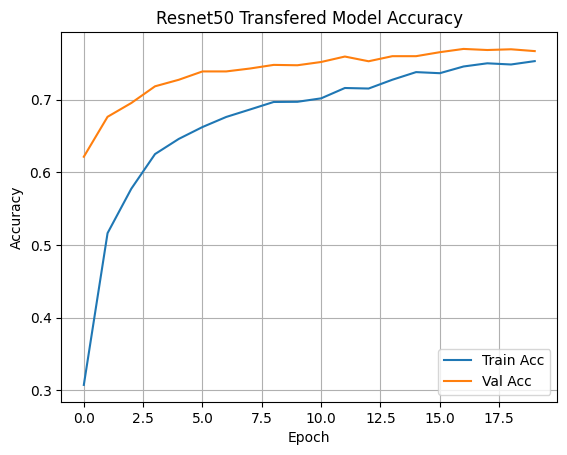

In [37]:
import matplotlib.pyplot as plt

plt.plot(history_base.history['accuracy'], label='Train Acc')
plt.plot(history_base.history['val_accuracy'], label='Val Acc')
plt.title('Base Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

plt.plot(history_augmentation.history['accuracy'], label='Train Acc')
plt.plot(history_augmentation.history['val_accuracy'], label='Val Acc')
plt.title('Augmented Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

plt.plot(history_resnet50.history['accuracy'], label='Train Acc')
plt.plot(history_resnet50.history['val_accuracy'], label='Val Acc')
plt.title('Resnet50 Transfered Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

**6. Test Prediction from Test-set**

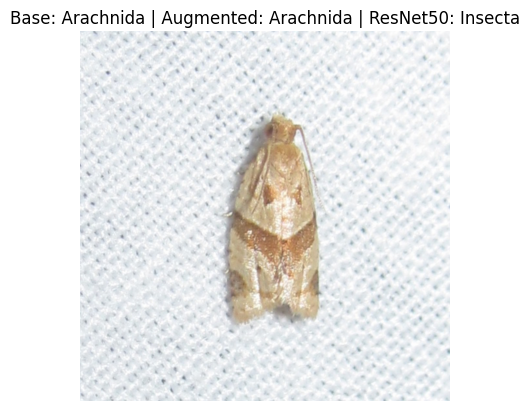

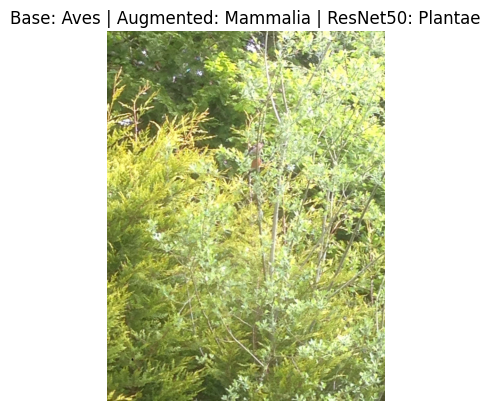

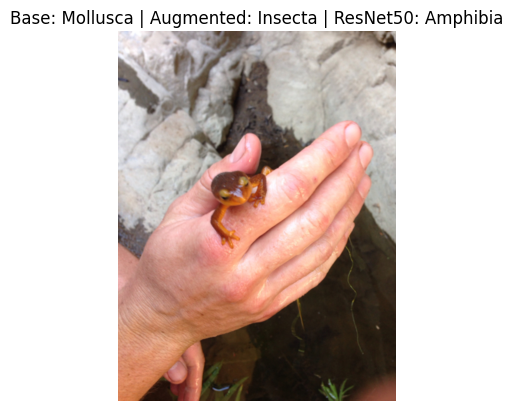

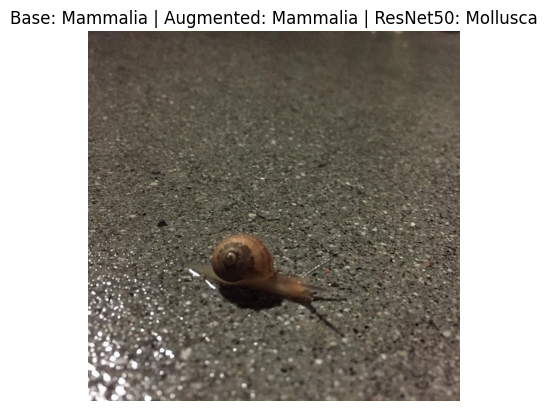

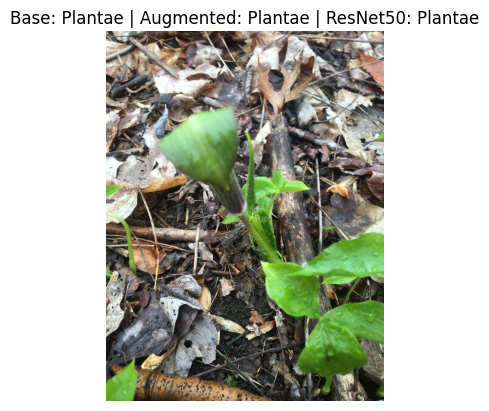

In [38]:
from tensorflow.keras.applications.resnet50 import preprocess_input as preprocess_resnet

import random
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import os

IMG_SIZE = (128, 128)
class_names = list(train_data.class_indices.keys())

# Randomly select 5 test images
random_images = random.sample(os.listdir(test_path), 5)
image_paths = [os.path.join(test_path, img) for img in random_images]

'''
Base and Augmented models were trained on:
- Size: (128, 128)
- Normalized with /255.0

ResNet50 expects:
- Size: (224, 224)
- Normalized with keras.applications.resnet50.preprocess_input()

=> Cannot feed a (128x128) image scaled to [0, 1] into ResNet50, it’ll produce junk predictions — even if the model is well-trained.
=> We apply different preprocess pipelines for each
'''

# Process base and augmented (CNN) models
def preprocess_image_custom(image_path):
    img = Image.open(image_path).convert('RGB')
    img = img.resize((128, 128))
    img_array = np.array(img) / 255.0
    return np.expand_dims(img_array, axis=0)

# Process ResNet50 model
def preprocess_image_resnet(image_path):
    img = Image.open(image_path).convert('RGB')
    img = img.resize((224, 224))
    img_array = np.array(img)
    img_array = preprocess_resnet(img_array)
    return np.expand_dims(img_array, axis=0)

for path in image_paths:
    # Predict with each model using appropriate preprocessing
    img_base = preprocess_image_custom(path)
    img_aug = preprocess_image_custom(path)
    img_r50 = preprocess_image_resnet(path)

    # Make predictions
    pred_base = model_base.predict(img_base, verbose=0)
    pred_aug = model_augmentation.predict(img_aug, verbose=0)
    pred_r50 = model_resnet50.predict(img_r50, verbose=0)

    # Extract predicted class labels
    class_base = class_names[np.argmax(pred_base)]
    class_aug = class_names[np.argmax(pred_aug)]
    class_r50 = class_names[np.argmax(pred_r50)]

    # Show image with predicted class names
    img = Image.open(path)
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Base: {class_base} | Augmented: {class_aug} | ResNet50: {class_r50}")
    plt.show()


**7. Save to Drive**

In [40]:
# Path
model_path = '/content/drive/MyDrive/COS30082/A1/model'

# Save the base model
model_base.save(f"{model_path}/cnn_base_model.h5")
print("✅ Base model saved.")

# Save the augmentation model
model_augmentation.save(f"{model_path}/cnn_augmented_model.h5")
print("✅ Augmented model saved.")

# Save the ResNet50 transferred model
model_resnet50.save(f"{model_path}/resnet50_transferred_model.keras")
print("✅ ResNet50 model saved.")

✅ ResNet50 model saved.
